In [2]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import img_as_float, io, restoration
from model import FFCNN



In [3]:
def fast_iterative_denoising_btb(y, f, mu_sequence, T, delta):
    """
    Fast Iterative Denoising Algorithm (BTB)

    Parameters:
        y: Input image (noisy)
        f: Denoiser function
        mu_sequence: Sequence of step sizes
        T: Maximum number of iterations
        delta: Convergence threshold

    Returns:
        x_denoised: Denoised image
    """
    x_prev = y.copy()  # Initialize previous denoised image as noisy image
    
    for t in range(T):
        # Convert numpy array to PyTorch tensor
        x_prev_tensor = torch.from_numpy(x_prev).permute(2, 0, 1).unsqueeze(0).float()
        
        # Apply denoiser function to previous denoised image
        x_next_tensor = f(x_prev_tensor)
        
        # Convert tensor back to numpy array
        x_next = x_next_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
        
        # Update current denoised image using hybrid Banach contraction principle
        x_current = (1 - mu_sequence[t]) * x_prev + mu_sequence[t] * x_next
        
        # Check convergence criterion
        if np.linalg.norm(x_current - x_prev) < delta:
            break  # Stop iteration if convergence criterion is met
        
        x_prev = x_current  # Update previous denoised image
        
    return x_current


def add_gaussian_noise(image, sigma):
    """
    Add Gaussian noise to an image

    Parameters:
        image: Input image
        sigma: Standard deviation of Gaussian noise

    Returns:
        image_noisy: Noisy image
    """
    noise = np.random.normal(0, sigma, image.shape)  # Generate Gaussian noise
    image_noisy = image + noise  # Add noise to image
    image_noisy = np.clip(image_noisy, 0, 1)  # Clip noisy image to [0, 1]
    
    return image_noisy


In [4]:
img_path = "noisy_image.png"

image = cv2.imread(img_path, cv2.IMREAD_COLOR)

noise = add_gaussian_noise(image, 1)

noisy_image = cv2.add(image, noise.astype(np.uint8))  # Convert noise to uint8 before adding
noisy_image = img_as_float(noisy_image)


In [5]:
file_model = "model.pth"

model = FFCNN()
model.load_state_dict(torch.load(file_model))
model.eval()

FFCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [12]:
mu_sequence = np.linspace(0.1, 0.2, 8)
T = 8
delta = 1e-4

# Apply the Fast Iterative Denoising Algorithm (BTB)
denoised_image = fast_iterative_denoising_btb(noisy_image, model, mu_sequence, T, delta)

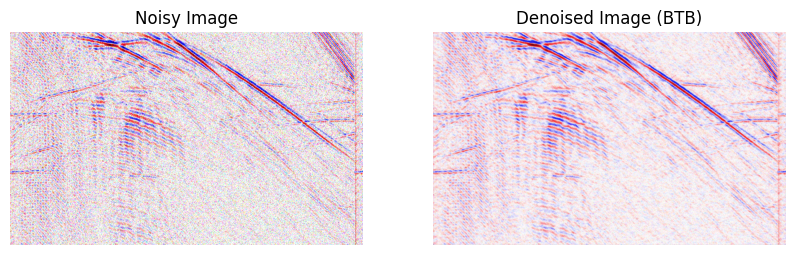

In [13]:
# Display the original and denoised images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image (BTB)')
plt.axis('off')

plt.show()